In [95]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score

from collections import defaultdict
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [ ]:
# 1. 샘플 더미 데이터 생성
np.random.seed(42)
n = 30000

지점 = np.random.choice(['서울', '부산', '대전'], n)
장소 = np.random.choice(['실내', '실외'], n)
상태 = np.random.choice(['정상', '주의', '위험'], n)
장비명 = np.random.choice(['A1', 'B2', 'C3'], n)
온도 = np.random.normal(25, 5, n)
진동 = np.random.normal(0.5, 0.2, n)
전류 = np.random.normal(3.0, 0.5, n)
압력 = np.random.normal(1.0, 0.1, n)
시작시간 = pd.to_datetime('2024-01-01') + pd.to_timedelta(np.random.randint(0, 60*24*30, size=n), unit='m')
종료시간 = 시작시간 + pd.to_timedelta(np.random.randint(30, 180, size=n), unit='m')  # 30분~3시간

에너지사용량 = 온도 * 0.5 + 전류 * 1.2 + np.random.normal(0, 0.5, n)
장비상태 = np.random.choice(['정상', '경고', '위험'], n)

df = pd.DataFrame({
    '지점': 지점,
    '장소': 장소,
    '상태': 상태,
    '장비명': 장비명,
    '온도': 온도,
    '진동': 진동,
    '전류': 전류,
    '압력': 압력,
    '시작시간': 시작시간,
    '종료시간': 종료시간,
    '에너지사용량': 에너지사용량,
    '장비상태': 장비상태
})

df = df.sort_values(['지점', '시작시간']).reset_index(drop=True)
df['시간차'] = (df['종료시간'] - df['시작시간']).dt.total_seconds() / 3600.0

#버전 1
# df['장비상태'] = df.apply(lambda row: (
#     '위험' if row['온도'] > 30 and row['진동'] > 0.8 else
#     '경고' if row['전류'] > 3.5 or row['압력'] < 0.9 else
#     '정상'), axis=1)

#버전2
# 예시: 과거 평균값에 따라 장비상태 결정
def define_future_state(df, offset_hours=3):
    result = []
    for i in range(len(df) - offset_hours):
        future_temp = df['온도'].iloc[i + offset_hours]
        future_vib  = df['진동'].iloc[i + offset_hours]
        result.append(
            '위험' if future_temp > 30 and future_vib > 0.7 else
            '경고' if future_temp > 26 or future_vib > 0.6 else
            '정상'
        )
    result.extend(['정상'] * offset_hours)  # 뒤쪽은 예외 처리
    return result

df['장비상태'] = define_future_state(df)

df


,지점,장소,상태,장비명,온도,진동,전류,압력,시작시간,종료시간,에너지사용량,장비상태,시간차
0,대전,실외,주의,A1,22.391509,0.464156,4.052915,0.947784,2024-01-01 00:06:00,2024-01-01 02:44:00,17.001006,경고,2.633333
1,대전,실외,위험,A1,28.311832,0.506709,2.840413,1.091780,2024-01-01 00:15:00,2024-01-01 02:29:00,18.370262,경고,2.233333
2,대전,실외,주의,C3,14.587645,0.831243,2.453830,1.020087,2024-01-01 00:15:00,2024-01-01 02:42:00,10.667127,경고,2.450000
3,대전,실내,주의,A1,32.294231,0.600313,3.042820,1.083600,2024-01-01 00:16:00,2024-01-01 02:53:00,19.794068,경고,2.616667
4,대전,실내,위험,C3,27.605973,0.335041,3.010542,0.894835,2024-01-01 00:28:00,2024-01-01 02:22:00,17.516010,경고,1.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,서울,실내,위험,C3,19.120317,0.376871,2.426536,1.003902,2024-01-30 23:44:00,2024-01-31 01:32:00,12.221560,경고,1.800000
29996,서울,실외,정상,B2,23.150553,0.809733,3.861731,0.926336,2024-01-30 23:50:00,2024-01-31 00:35:00,16.602925,경고,0.750000
29997,서울,실외,정상,C3,27.613851,0.720415,3.689537,1.002861,2024-01-30 23:57:00,2024-01-31 02:37:00,18.341525,정상,2.666667
29998,서울,실내,위험,C3,19.629081,0.612630,3.211828,1.128565,2024-01-30 23:57:00,2024-01-31 00:54:00,13.404039,정상,0.950000


In [112]:
print(df['장비상태'].value_counts(normalize=True))

장비상태
경고    0.576800
정상    0.398133
위험    0.025067
Name: proportion, dtype: float64


In [ ]:
print(df['장비상태'].value_counts(normalize=True))

장비상태
경고    0.591133
정상    0.398133
위험    0.010733
Name: proportion, dtype: float64


In [108]:
print(df['장비상태'].value_counts(normalize=True))

장비상태
경고    0.540167
정상    0.452000
위험    0.007833
Name: proportion, dtype: float64


In [103]:
print(df['장비상태'].value_counts(normalize=True))

장비상태
정상    0.606367
경고    0.382900
위험    0.010733
Name: proportion, dtype: float64


In [83]:
#중복된 값 확인
df[df.duplicated('시작시간', keep=False)]

,지점,장소,상태,장비명,온도,진동,전류,압력,시작시간,종료시간,에너지사용량,장비상태,시간차
16,대전,실내,정상,C3,15.578554,0.255611,2.417713,1.068799,2024-01-01 03:51:00,2024-01-01 06:20:00,10.643654,경고,2.483333
32,대전,실내,정상,A1,34.318991,0.391002,3.537667,0.984227,2024-01-01 12:54:00,2024-01-01 15:09:00,21.319390,경고,2.250000
34,대전,실내,정상,B2,25.413613,0.306064,2.743162,0.907638,2024-01-01 13:36:00,2024-01-01 14:25:00,15.976370,정상,0.816667
43,대전,실외,정상,B2,21.151707,0.429812,2.934867,0.937211,2024-01-01 19:07:00,2024-01-01 21:11:00,13.768822,정상,2.066667
60,대전,실외,정상,C3,32.278535,0.400115,2.604855,1.046194,2024-01-02 00:49:00,2024-01-02 02:25:00,18.876990,정상,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,서울,실내,주의,B2,22.319134,0.745258,3.401404,1.043525,2024-01-30 11:51:00,2024-01-30 14:02:00,16.138901,경고,2.183333
4966,서울,실내,정상,B2,22.280876,0.634576,3.282481,0.973401,2024-01-30 13:41:00,2024-01-30 14:45:00,15.707658,경고,1.066667
4973,서울,실외,주의,C3,30.173367,0.858963,1.751117,0.951919,2024-01-30 16:01:00,2024-01-30 18:28:00,16.728555,경고,2.450000
4984,서울,실내,주의,A1,17.046175,0.375966,3.187290,0.922425,2024-01-30 20:10:00,2024-01-30 22:36:00,12.002610,정상,2.433333


2단계: 전처리 및 시퀀스 생성

3단계: LSTM 모델 설계 (회귀 + 분류 출력)

4단계: 학습 루프와 평가 지표 구현

5단계: 외부 입력 테스트 & 예측 결과 해석

In [117]:
# 2단계 전처리 및 시퀀스 생성
#범주형 컬럼 인코딩 
cat_cols = ['지점','장소','상태','장비명']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
# 타켓 인코딩 (분류용)
target_cls_le = LabelEncoder()
df['장비상태_코드'] = target_cls_le.fit_transform(df['장비상태'])
#정규화(입력 features, 회귀타겟 따로)
features = ['지점','장소','상태','장비명','온도','진동','전류','압력','시간차']
target_reg = '에너지사용량'
target_cls = '장비상태_코드'
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target_reg]])
#데이터 통합
# data_scaled = np.hstack([x_scaled,y_scaled,df[[target_cls]].values])
# data_scaled = np.hstack([x_scaled, y_scaled, df[[target_cls]].to_numpy()])  # ← 이건 OK
data_scaled = np.hstack([x_scaled, y_scaled, df[target_cls].to_numpy().reshape(-1, 1)])  # ← Fix: reshape to 2D
#지점별로 시퀀스 분리
seq_len = 10 
max_n = 1*24 # 최대 예측 n (1주일)

def create_seq(df, data_scaled, seq_len,max_n):
    xs , ns, y_regs, y_clss = [],[],[],[] #	입력 시퀀스, n시간 뒤, 회귀 타겟, 분류 타겟 저장용 리스트
    for site in df['지점'].unique():
        site_idx = (df['지점'] == site)
        site_data = data_scaled[site_idx.to_numpy()] #스케일된 데이터 중 해당 지점 데이터 추출
        for i in range(len(site_data)-seq_len-max_n):
            seq_x = site_data[i:i+seq_len,:-2]
            for n in range(1, max_n+1):
                if i +seq_len + n >= len(site_data): #	범위를 초과하는 경우 생략
                    continue
                xs.append(seq_x) #입력 시퀀스 저장
                ns.append([n/max_n]) # 정규화된 n
                y_regs.append(site_data[i+seq_len+n,-2]) #n시간 뒤 에너지 사용량 (회귀 타겟) 저장 에너지 소비량
                y_clss.append(site_data[i+seq_len+n,-1]) #n시간 뒤 장비 상태 (분류 타겟) 저장 분류타겟 장비상태 코드 
    return np.array(xs),np.array(ns),np.array(y_regs),np.array(y_clss)


In [124]:
#3단계: LSTM 멀티태스크 모델 구성 (회귀 + 분류)
#모델1
'''
class LSTMwithMultiOutput(nn.Module):
    def __init__(self, input_dim,hidden_dim,num_layers,num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc_n = nn.Linear(1,hidden_dim)
        self.dropout = nn.Dropout(0.1)
        self.fc_combied = nn.Linear(hidden_dim*2,hidden_dim)
        #출력레이어 : 회귀 + 분류
        self.out_reg = nn.Linear(hidden_dim,1)
        self.out_cls = nn.Linear(hidden_dim,num_classes)
        
    def forward(self,x,n):
        lstm_out,_ = self.lstm(x)
        last_out = lstm_out[:,-1,:]
        n_feat = self.fc_n(n)
        combined = torch.cat([last_out,n_feat],dim=1)
        combined = self.dropout(self.fc_combied(combined))
        reg_out = self.out_reg(combined).squeeze(1)
        cls_out = self.out_cls(combined)
        return reg_out, cls_out 
'''
# 모델2
class LSTMwithMultiOutput(nn.Module):
    def __init__(self, input_dim,hidden_dim,num_layers,num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # n 피처용 MLP
        self.fc_n = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        # 결합 후 MLP
        self.fc_combined = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1)
        )
        self.out_reg = nn.Linear(hidden_dim, 1)
        self.out_cls = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, n):
        lstm_out, _ = self.lstm(x)
        last_out   = lstm_out[:, -1, :]
        n_feat     = self.fc_n(n)           # now non-linear
        comb       = torch.cat([last_out, n_feat], dim=1)
        comb       = self.fc_combined(comb) # now non-linear + BN
        return self.out_reg(comb).squeeze(1), self.out_cls(comb)

#모델3 bilstm
'''
class BiLSTMwithMultiOutput(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            batch_first=True, bidirectional=True)

        # n 피처 MLP
        self.fc_n = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )

        # 결합 후 MLP (LSTM 2배 + n 1배 → total: 3배)
        self.fc_combined = nn.Sequential(
            nn.Linear(hidden_dim * 2 + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.1)
        )

        self.out_reg = nn.Linear(hidden_dim, 1)
        self.out_cls = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, n):
        lstm_out, _ = self.lstm(x)  # (B, T, 2*H)
        last_out = lstm_out[:, -1, :]  # (B, 2*H)

        n_feat = self.fc_n(n)  # (B, H)

        # Concatenate (B, 3*H)
        combined = torch.cat([last_out, n_feat], dim=1)
        combined = self.fc_combined(combined)

        return self.out_reg(combined).squeeze(1), self.out_cls(combined)
'''
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight  # 클래스 가중치 (불균형 대응)

    def forward(self, input, target):
        logp = F.log_softmax(input, dim=1)
        p = torch.exp(logp)
        logp = (1 - p) ** self.gamma * logp
        loss = F.nll_loss(logp, target, weight=self.weight)
        return loss 

    
class MultiTargetDataset(Dataset):
    def __init__(self,x,n,y_regs,y_clss):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.n = torch.tensor(n,dtype=torch.float32)
        self.y_reg = torch.tensor(y_regs,dtype=torch.float32)
        self.y_cls =torch.tensor(y_clss,dtype=torch.long)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx],self.n[idx],self.y_reg[idx],self.y_cls[idx]

#data
X,n_array,y_regs,y_clss = create_seq(df,data_scaled,seq_len,max_n)

#hyper parameter
input_dim = X.shape[2]
hidden_dim = 128
num_layers = 2
num_classes = len(np.unique(y_clss))
batch_size = 64
epochs = 10
lr = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = LSTMwithMultiOutput(input_dim,hidden_dim,num_layers,num_classes).to(device)
# model = BiLSTMwithMultiOutput(input_dim,hidden_dim,num_layers,num_classes).to(device)
dataset = MultiTargetDataset(X,n_array,y_regs,y_clss)
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)


unique_classes = np.unique(y_clss)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_clss)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


loss_fn_reg = nn.MSELoss()
# loss_fn_cls = nn.CrossEntropyLoss(weight=weights_tensor)
loss_fn_cls = FocalLoss(gamma=2.0,weight=weights_tensor)

optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)




In [125]:
from collections import Counter
print(Counter(y_clss))


Counter({0.0: 413967, 2.0: 285602, 1.0: 17983})


In [120]:
for epoch in range(epochs):
    model.train()
    total_loss, total_reg_loss, total_cls_loss = 0, 0, 0
    all_preds, all_labels = [], []

    for xb, nb, yb_reg, yb_cls in loader:
        xb, nb = xb.to(device), nb.to(device)
        yb_reg, yb_cls = yb_reg.to(device), yb_cls.to(device)

        pred_reg, pred_cls = model(xb, nb)  # 회귀, 분류 예측값
        # print(yb_reg.min().item(), yb_reg.max().item())  # 정규화된 범위인지
        # print(pred_reg.min().item(), pred_reg.max().item())  # 튀는 값 있는지
        # print(pred_reg.shape, yb_reg.shape)

        # 손실 계산
        loss_reg = loss_fn_reg(pred_reg, yb_reg)
        loss_cls = loss_fn_cls(pred_cls, yb_cls)
        
        alpha = 1.0  # 회귀 손실 비중
        beta = 2.0   # 분류 손실 비중 (더 작게 시작)

        loss = alpha * loss_reg + beta * loss_cls

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()

        total_loss += loss.item()
        total_reg_loss += loss_reg.item()
        total_cls_loss += loss_cls.item()

        # 분류 정확도 계산
        all_preds.extend(pred_cls.argmax(dim=1).cpu().numpy())
        all_labels.extend(yb_cls.cpu().numpy())
        

    n_batches = len(loader)
        
    scheduler.step()
    curr_lr = optimizer.param_groups[0]['lr']

    avg_loss = total_loss / n_batches
    avg_reg  = total_reg_loss  / n_batches
    avg_cls  = total_cls_loss  / n_batches
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')       # 다중 클래스용
    precision = precision_score(all_labels, all_preds, average='macro',zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro')
    print(f"[{epoch+1}] LR = {curr_lr:.5f} Loss: {avg_loss:.4f} | Reg: {avg_reg:.4f} | Cls: {avg_cls:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | precision: {precision:.4f} | recall: {recall:.4f}")

[1] LR = 0.01000 Loss: 1.0031 | Reg: 0.0153 | Cls: 0.4939 | Acc: 0.4220 | F1: 0.3159 | precision: 0.3337 | recall: 0.3338
[2] LR = 0.01000 Loss: 0.9953 | Reg: 0.0143 | Cls: 0.4905 | Acc: 0.4284 | F1: 0.3179 | precision: 0.3331 | recall: 0.3323
[3] LR = 0.00500 Loss: 0.9957 | Reg: 0.0144 | Cls: 0.4907 | Acc: 0.4308 | F1: 0.3184 | precision: 0.3330 | recall: 0.3316
[4] LR = 0.00500 Loss: 0.9897 | Reg: 0.0142 | Cls: 0.4878 | Acc: 0.4601 | F1: 0.3292 | precision: 0.3342 | recall: 0.3347
[5] LR = 0.00500 Loss: 0.9898 | Reg: 0.0142 | Cls: 0.4878 | Acc: 0.4697 | F1: 0.3303 | precision: 0.3329 | recall: 0.3327
[6] LR = 0.00250 Loss: 0.9898 | Reg: 0.0142 | Cls: 0.4878 | Acc: 0.4668 | F1: 0.3296 | precision: 0.3327 | recall: 0.3326
[7] LR = 0.00250 Loss: 0.9873 | Reg: 0.0141 | Cls: 0.4866 | Acc: 0.4919 | F1: 0.3313 | precision: 0.3324 | recall: 0.3329
[8] LR = 0.00250 Loss: 0.9877 | Reg: 0.0141 | Cls: 0.4868 | Acc: 0.4835 | F1: 0.3318 | precision: 0.3330 | recall: 0.3330
[9] LR = 0.00125 Loss: 0

In [121]:
# 예측 → 정수 클래스 → 문자열로 디코딩
model.eval()  # <--- Add this line to set model to eval mode
with torch.no_grad():
    x_sample = X[0]                # shape: (seq_len, input_dim)
    n_sample = n_array[0]
    x_tensor = torch.tensor(x_sample, dtype=torch.float32).unsqueeze(0).to(device)
    n_tensor = torch.tensor(n_sample, dtype=torch.float32).unsqueeze(0).to(device)

    pred_energy, pred_state = model(x_tensor, n_tensor)
    pred_state_label = target_cls_le.inverse_transform([int(pred_state.argmax(1).item())])[0]
    real_state_label = target_cls_le.inverse_transform([int(y_clss[0])])[0]
    pred_energy_cpu = pred_energy.detach().cpu().numpy().reshape(-1, 1)
    pred_energy_inv = scaler_y.inverse_transform(pred_energy_cpu)
print(f"예측 장비 상태: {pred_state_label}, 실제 상태: {real_state_label}")
print(f"예측 에너지 사용량 (역정규화값): {pred_energy_inv.item():.4f}")

예측 장비 상태: 정상, 실제 상태: 경고
예측 에너지 사용량 (역정규화값): 16.0599


In [129]:
#모델 저장
# torch.save(model,'../model/bilstm_0.48.pt')
bilstms = torch.load('../model/bilstm_0.48.pt', weights_only=False)

In [143]:
#입력 n 시간뒤 예측
sample_seq = X[10000]
sample_seq_tensor = torch.tensor(sample_seq,dtype=torch.float32).unsqueeze(0).to(device)

def predict_n_hours_ahead(n_hour, model):
    n_norm = n_hour / max_n
    n_tensor = torch.tensor([[n_norm]], dtype=torch.float32).to(device)  # shape (1, 1)
    
    with torch.no_grad():
        model.eval()
        pred_reg, pred_cls = model(sample_seq_tensor, n_tensor)
        pred_energy = scaler_y.inverse_transform(pred_reg.cpu().numpy().reshape(-1, 1))[0][0]
        pred_cls_label = target_cls_le.inverse_transform([torch.argmax(pred_cls, dim=1).item()])[0]
    return pred_energy, pred_cls_label

n = 3 # 12시간 뒤 예측
에너지, 상태 = predict_n_hours_ahead(n,bilstms)
print(f"{n}시간 뒤 에너지 사용량: {에너지:.2f}, 장비 상태: {상태}")

3시간 뒤 에너지 사용량: 16.07, 장비 상태: 정상


c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 

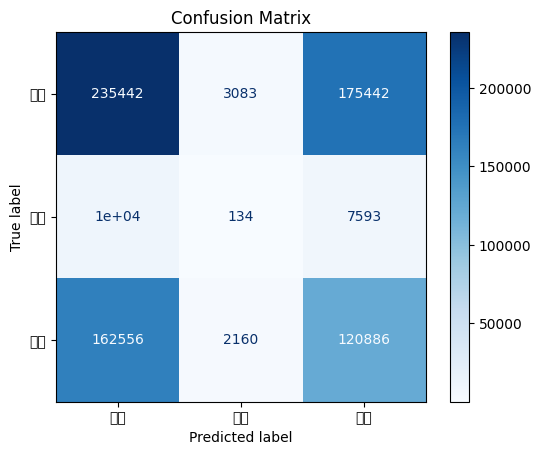

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_cls_le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [101]:
print("Class별 F1:", f1_score(all_labels, all_preds, average=None))

Class별 F1: [3.71370370e-01 2.36239074e-04 6.24669214e-01]


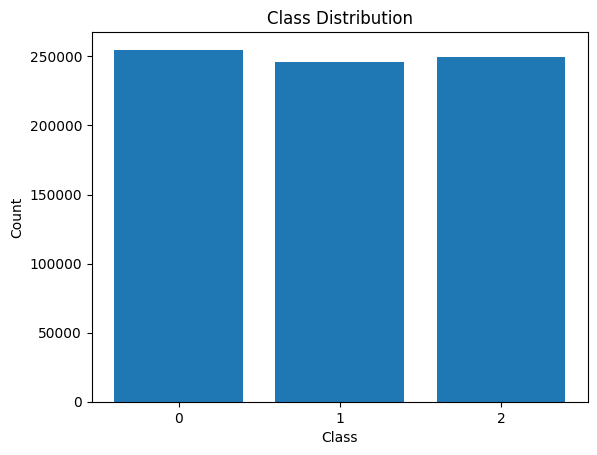

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_clss, bins=np.arange(num_classes+1)-0.5, rwidth=0.8)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(num_classes))
plt.show()
